In [1]:
# Importing libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score
from sklearn.utils import parallel_backend
from pyearth import Earth
from patsy import dmatrix
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import warnings
from pyearth import Earth
from sklearn.model_selection import RandomizedSearchCV, KFold


In [2]:
# Loading data
X_test = pd.read_csv('data/X_test.csv')
X_train = pd.read_csv('data/X_train.csv')
y_test = pd.read_csv('data/y_test.csv')
y_train = pd.read_csv('data/y_train.csv')

### Coarse Grid Hyperparameter Optimization

In [4]:
# Coarse grid search for hyperparameter optimization
    # Note: I fit 25 models here and it took approximately an hour and a half (90 mins)

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning)
init_search_df = pd.DataFrame(columns = ['degree', 'max_terms', 'rmse'])


# Lists to store the values for plotting
degrees = []
max_terms_values = []
mean_scores = []

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in range(1, 11, 2):
    print('Fitting models for degree = ', degree)

    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(400, 1201, 200):
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_root_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Saving the values for plotting
        degrees.append(degree)
        max_terms_values.append(terms)
        mean_scores.append(mean_score)
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
# Training a new MARS model on the entire training set using the optimal parameters
model = Earth(max_terms = opt_max_terms, max_degree = opt_degree)
model.fit(X_train, y_train)

Fitting models for degree =  1
     Fitting models for degree =  1 and max_terms =  400
     Fitting models for degree =  1 and max_terms =  600
     Fitting models for degree =  1 and max_terms =  800
     Fitting models for degree =  1 and max_terms =  1000
     Fitting models for degree =  1 and max_terms =  1200
Fitting models for degree =  3
     Fitting models for degree =  3 and max_terms =  400
     Fitting models for degree =  3 and max_terms =  600
     Fitting models for degree =  3 and max_terms =  800
     Fitting models for degree =  3 and max_terms =  1000
     Fitting models for degree =  3 and max_terms =  1200
Fitting models for degree =  5
     Fitting models for degree =  5 and max_terms =  400
     Fitting models for degree =  5 and max_terms =  600
     Fitting models for degree =  5 and max_terms =  800
     Fitting models for degree =  5 and max_terms =  1000
     Fitting models for degree =  5 and max_terms =  1200
Fitting models for degree =  7
     Fitting mo

Earth(max_degree=5, max_terms=400)

In [12]:
# Fitting the model 
model = Earth(max_terms = 400, max_degree = 5, feature_importance_type = "gcv") # Using gcv here for feature importance 
model.fit(X_train, y_train) 

# Creating a dictionary of feature importances 
# Values = feature importance values 
importances = model.feature_importances_

# Create dictionary with non-zero feature importances
important_features = {feature: importances[i] for i, feature in enumerate(X_train.columns) if importances[i] != 0}

# Creating a df from the important_features dictionary
features_df = pd.DataFrame.from_dict(important_features, orient='index', columns=['importance'])

# Sorting by desc importance / reset index / rename cols 
features_df = features_df.sort_values(by='importance', ascending=False)
features_df = features_df.reset_index().rename(columns={'index': 'predictor'})

# Print the resulting DataFrame
print(features_df)

/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


               predictor  importance
0                alcohol    0.299499
1                density    0.269187
2    free sulfur dioxide    0.115497
3         residual sugar    0.088609
4              sulphates    0.079322
5       volatile acidity    0.065634
6   total sulfur dioxide    0.043120
7                     pH    0.017919
8               type_red    0.015335
9          fixed acidity    0.005260
10             chlorides    0.000618


/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [ ]:
# Defining the initial base model 
mars_init = Earth(max_terms = 600, max_degree = 6)
mars_init.fit(X_train, y_train)
print(mars_init.summary())

/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()


Earth Model
-------------------------------------------------------------------------------------------------------------------------------------
Basis Function                                                                                                  Pruned  Coefficient  
-------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                                                                                                     No      8.8923       
h(alcohol-0.869565)                                                                                             No      -16.3262     
h(0.869565-alcohol)                                                                                             Yes     None         
volatile acidity                                                                                                Yes     None         
h(density-0.0213997)*h(0.869565-alcohol)          

/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [ ]:
# Making predictions
pred = mars_init.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred = [round(p) for p in pred]

In [ ]:
print("Coarse Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred)))

Coarse Grid Tuning MARS Model Test RMSE: 0.7922703501282297


### Fine Grid Hyperparameter Optimization

In [ ]:
# Finer grid search - Thinking that this will take around 64 minutes if I timed it right
    # 18 models here total (vs the 25 in the larger coarse grid search)
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category = FutureWarning) # Got 7 and 800

# Initializing optimal parameters & best score variables
opt_degree = 1
opt_max_terms = 500
best_score = -float('inf')

# Outer loop for degree
for degree in [6, 7]: 
    print('Fitting models for degree = ', degree)
    # Creating a MARS model with the current degree and max_terms
    model = Earth(max_terms = 500, max_degree = degree)
    
    # Inner loop for max_terms
    for terms in range(700, 801, 50): # Now looking from 300 to 600 in steps of 50
        print('     Fitting models for degree = ', degree, 'and max_terms = ', terms)
        # Setting the current max_terms
        model.max_terms = terms
        
        # 5-fold cross validation
        scores = cross_val_score(model,
                                 X_train,
                                 y_train, 
                                 cv = 5, 
                                 scoring = 'neg_root_mean_squared_error')
        
        # Computing mean score
        mean_score = scores.mean()
        
        # Checking if mean score is better than the current best score
        if mean_score > best_score:
            best_score = mean_score
            opt_degree = degree
            opt_max_terms = terms
            
print("Optimal degree in fine grid search = ", degree)
print("Optimal max_terms in fine grid search = ", terms)

Fitting models for degree =  6
     Fitting models for degree =  6 and max_terms =  700


In [4]:
# Defining the initial base model 
mars_model = Earth(max_terms = 800, max_degree = 7)
mars_model.fit(X_train, y_train)

/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


Earth(max_degree=7, max_terms=800)

In [5]:
# Making predictions
pred_opt = mars_model.predict(X_test)

# Rounding predictions to the nearest integer 
rounded_pred_opt = [round(p) for p in pred_opt]

In [6]:
# Printing the test RMSE of the fine grid tuning model
print("Fine Grid Tuning MARS Model Test RMSE:", np.sqrt(mean_squared_error(y_test, rounded_pred_opt)))

Fine Grid Tuning MARS Model Test RMSE: 0.790326125479466


### Plotting Residuals & Actual vs Predicted Values

In [7]:
# Converting rounded_pred_opt to a df
rounded_pred_opt = pd.Series(rounded_pred_opt, name='quality')
rounded_pred_opt = rounded_pred_opt.to_frame().rename(columns={'quality': 'quality'})


# Calculate residuals
residuals = y_test - rounded_pred_opt

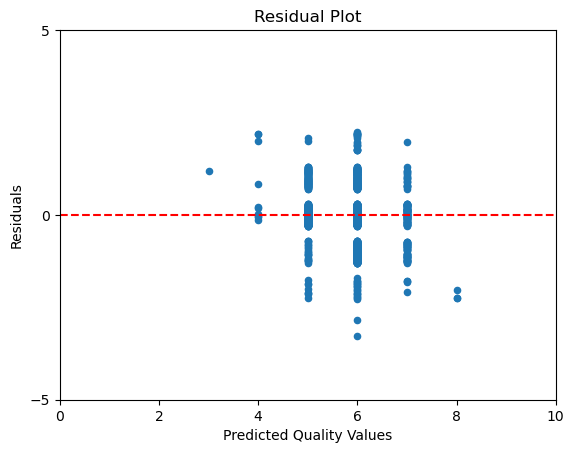

In [8]:
# Plotting residuals 
df = pd.concat([rounded_pred_opt, residuals], axis=1)
df.columns = ['quality', 'residuals']

# Jittering the points
jitter_amount = 0.3
df['jittered_residuals'] = df['residuals'] + np.random.uniform(low=-jitter_amount, high=jitter_amount, size=len(df))

# Plotting the points
residual_mars_plt = df.plot(x='quality', y='jittered_residuals', kind='scatter')
residual_mars_plt.axhline(y=0, color='red', linestyle='--')  # Add line y = 0
residual_mars_plt.set_xlabel('Predicted Quality Values')
residual_mars_plt.set_ylabel('Residuals')
residual_mars_plt.set_title('Residual Plot')
residual_mars_plt.set_xlim([0, 10])
residual_mars_plt.set_ylim([-5, 5])
residual_mars_plt.set_yticks([-5, 0, 5])

# Saving the PNG
residual_mars_plt.get_figure().savefig('residual_plot_MARS.png', dpi = 300)

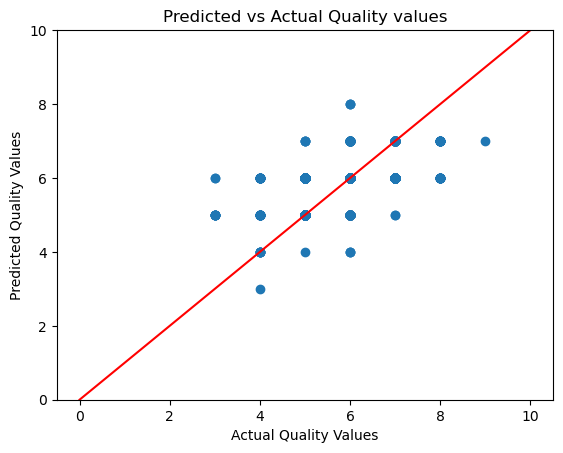

In [9]:
# Plotting predicted vs actual y values
plt.scatter(y_test, rounded_pred_opt)
plt.xlabel('Actual Quality Values')
plt.ylabel('Predicted Quality Values')
plt.title('Predicted vs Actual Quality values')
plt.ylim([0, 10])
plt.plot([0, 10], [0, 10], color='red')
plt.show()

### Creating a Model to Predict Residuals

In [10]:
# Fit a MARS model to predict residuals
residual_model = Earth()
residual_model.fit(rounded_pred_opt, residuals)

# Make predictions on test set
residuals_pred = residual_model.predict(rounded_pred_opt)

# Calculate overall RMSE of the residual model
residual_model_rmse = np.sqrt(mean_squared_error(residuals, residuals_pred))

print("RMSE of Residual Model: {:.2f}".format(residual_model_rmse))

RMSE of Residual Model: 0.76


/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:813: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/lilawells/opt/anaconda3/lib/python3.9/site-packages/pyearth/earth.py:1066: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


### Finalizing the Model & Predictions

In [11]:
# Making predictions using the optimized MARS model and the residuals model as well
    # Optimized MARS model predictions held in 'rounded_pred_opt'

# Making predictions with the residuals model
residuals_pred_unrounded = residual_model.predict(rounded_pred_opt)

# Rounding predictions to the nearest integer 
residuals_pred = [round(p) for p in residuals_pred_unrounded]
residuals_pred_series = pd.Series(residuals_pred, name='quality') # Making residuals into a series

# Add predicted residuals to y_pred to get final predictions
y_pred_final = pd.concat([rounded_pred_opt, residuals_pred_series], axis=1).sum(axis=1)

# Calculating the final MARS model RMSE 
print("Test RMSE of Fine Grid MARS Model & Residuals Model:", np.sqrt(mean_squared_error(y_test, y_pred_final)))

Test RMSE of Fine Grid MARS Model & Residuals Model: 0.7760848486523186
